In [1]:
from tinylang import PCFG, train, init_model
from transformers import GPT2Config, GPT2LMHeadModel
import torch

from sklearn.decomposition import PCA
import pandas as pd
import plotnine as p9
from sklearn.feature_selection import r_regression

device = "cuda:0" if torch.cuda.is_available() else "cpu"

/juice2/scr2/aryaman/tinylang/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pcfg = PCFG(num_terminals=20, num_nonterminals=10, max_rhs_len=10, max_rules_per_nt=5, max_depth=10, head_position="left", mask_nonquery=False)
# pcfg = PCFG(num_terminals=20, num_nonterminals=10, max_rhs_len=4, max_rules_per_nt=3, max_depth=5, head_position="left")

In [3]:
model_dict = {}
loss_dict = {}

# defaults
n_layer = 2
n_embd = 64
n_head = 2
n_inner = 4

for n_layer in range(0, 4):
# for n_embd in [16, 32, 64, 128]:   
# for n_head in [1, 2, 4, 8]:
# for n_inner in [0.5, 1, 2, 4]:
    config = GPT2Config(
        vocab_size=pcfg.vocab_size,
        n_positions=1024,
        n_embd=n_embd,
        n_layer=n_layer,
        n_head=n_head,
        n_inner=int(n_inner * n_embd),
        activation_function="gelu_new",
        resid_pdrop=0.0,
        embd_pdrop=0.0,
        attn_pdrop=0.0,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        summary_type="cls_index",
    )
    model = GPT2LMHeadModel(config).to(device)
    losses = train(model, pcfg, num_steps=10000)
    model.eval()
    loss_dict[n_layer] = losses
    model_dict[n_layer] = model


Parameters: 0.067264M


Training: 100%|█| 10000/10000 [00:58<00:00, 170.96it/s, eval_loss=2.58, eval_prob=0.0694, eval_prob_CHILD=0.113, eval_prob_PAREN


Parameters: 0.117248M


Training: 100%|█| 10000/10000 [01:13<00:00, 135.47it/s, eval_loss=0.919, eval_prob=0.276, eval_prob_CHILD=0.184, eval_prob_PAREN


Parameters: 0.167232M


Training: 100%|█| 10000/10000 [01:30<00:00, 109.95it/s, eval_loss=0.829, eval_prob=0.397, eval_prob_CHILD=0.291, eval_prob_PAREN


Parameters: 0.217216M


Training: 100%|█| 10000/10000 [01:55<00:00, 86.58it/s, eval_loss=0.807, eval_prob=0.391, eval_prob_CHILD=0.166, eval_prob_PARENT


KeyboardInterrupt: 

In [4]:
combined_cols = []
for d in loss_dict:
    for i in range(len(loss_dict[d]["train_loss"])):
        add = {metric: loss_dict[d][metric][i] for metric in loss_dict[d]}
        add["index"] = i
        add["d"] = d
        combined_cols.append(add)
df = pd.DataFrame(combined_cols)
df = df.melt(id_vars=["index", "d"])
df

,index,d,variable,value
0,0,0,train_loss,3.276508
1,1,0,train_loss,3.282870
2,2,0,train_loss,3.269168
3,3,0,train_loss,3.270894
4,4,0,train_loss,3.271943
...,...,...,...,...
239995,9995,3,eval_prob_CHILD,0.179988
239996,9996,3,eval_prob_CHILD,0.176903
239997,9997,3,eval_prob_CHILD,0.174926
239998,9998,3,eval_prob_CHILD,0.170105


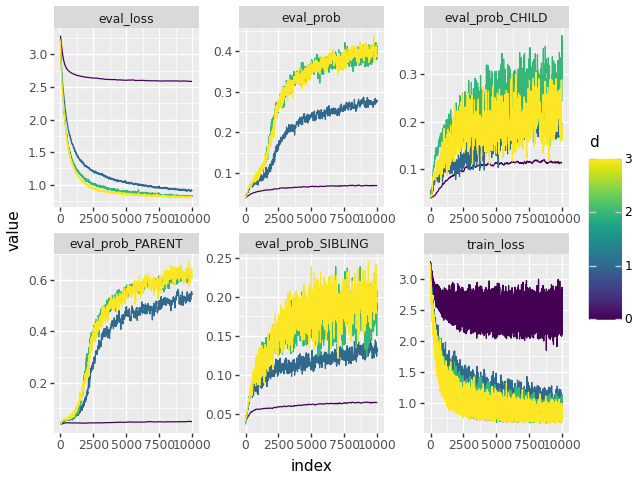

In [5]:
%config InlineBackend.figure_format = 'png'

plot = (
    p9.ggplot(df, p9.aes(x="index", y="value", color="d", group="d")) +
    p9.geom_line() +
    p9.facet_wrap("variable", scales="free") +
    p9.labs(fill="layers")
    # p9.scale_x_log10()
)
plot.show()

In [9]:
model_dict = {}
loss_dict = {}

# defaults
n_layer = 2
n_embd = 64
n_head = 2
n_inner = 4

# for n_layer in range(0, 4):
for n_embd in [16, 32, 64, 128]:   
# for n_head in [1, 2, 4, 8]:
# for n_inner in [0.5, 1, 2, 4]:
    config = GPT2Config(
        vocab_size=pcfg.vocab_size,
        n_positions=1024,
        n_embd=n_embd,
        n_layer=n_layer,
        n_head=n_head,
        n_inner=int(n_inner * n_embd),
        activation_function="gelu_new",
        resid_pdrop=0.0,
        embd_pdrop=0.0,
        attn_pdrop=0.0,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        summary_type="cls_index",
    )
    model = GPT2LMHeadModel(config).to(device)
    losses = train(model, pcfg, num_steps=10000)
    model.eval()
    loss_dict[n_embd] = losses
    model_dict[n_embd] = model

Parameters: 0.023376M


Training: 100%|█| 10000/10000 [01:31<00:00, 108.77it/s, eval_loss=1.48, eval_prob=0.0927, eval_prob_CHILD=0.152, eval_prob_PAREN


Parameters: 0.05904M


Training: 100%|█| 10000/10000 [01:31<00:00, 109.11it/s, eval_loss=1.07, eval_prob=0.196, eval_prob_CHILD=0.205, eval_prob_PARENT


Parameters: 0.167232M


Training: 100%|█| 10000/10000 [01:33<00:00, 107.35it/s, eval_loss=0.815, eval_prob=0.332, eval_prob_CHILD=0.128, eval_prob_PAREN


Parameters: 0.531072M


Training: 100%|█| 10000/10000 [01:32<00:00, 108.16it/s, eval_loss=0.799, eval_prob=0.332, eval_prob_CHILD=0.162, eval_prob_PAREN


In [10]:
combined_cols = []
for d in loss_dict:
    for i in range(len(loss_dict[d]["train_loss"])):
        add = {metric: loss_dict[d][metric][i] for metric in loss_dict[d]}
        add["index"] = i
        add["d"] = d
        combined_cols.append(add)
df = pd.DataFrame(combined_cols)
df = df.melt(id_vars=["index", "d"])
df

,index,d,variable,value
0,0,16,train_loss,3.231422
1,1,16,train_loss,3.236409
2,2,16,train_loss,3.235879
3,3,16,train_loss,3.224742
4,4,16,train_loss,3.232669
...,...,...,...,...
239995,9995,128,eval_prob_CHILD,0.173213
239996,9996,128,eval_prob_CHILD,0.170835
239997,9997,128,eval_prob_CHILD,0.169199
239998,9998,128,eval_prob_CHILD,0.165263


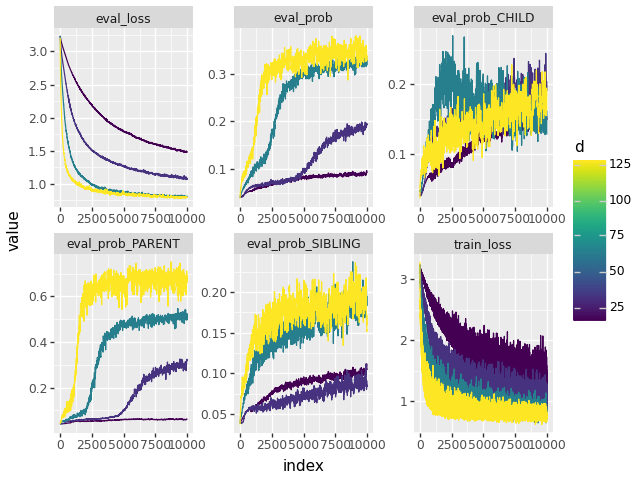

In [11]:
%config InlineBackend.figure_format = 'png'

plot = (
    p9.ggplot(df, p9.aes(x="index", y="value", color="d", group="d")) +
    p9.geom_line() +
    p9.facet_wrap("variable", scales="free") +
    p9.labs(fill="hidden dim")
    # p9.scale_x_log10()
)
plot.show()